In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, GlobalAveragePooling1D

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os, re, json, functools

plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=2811
np.random.seed(seed)
tf.random.set_seed(seed)





TensorFlow 2.x selected.


In [3]:
pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)
     |████████████████████████████████| 122kB 4.6MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.25.7
    Uninstalling urllib3-1.25.7:
      Successfully uninstalled urllib3-1.25.7


In [0]:
os.environ['KAGGLE_USERNAME'] = "karenvaldez"
os.environ['KAGGLE_KEY'] = "5912caabf0d1fa350842f382da374953"

In [5]:
#https://www.kaggle.com/rounakbanik/the-movies-dataset
!kaggle datasets download rounakbanik/the-movies-dataset


 97% 221M/228M [00:01<00:00, 171MB/s]
100% 228M/228M [00:01<00:00, 181MB/s]


In [6]:
!unzip -o 'the-movies-dataset.zip'


Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


In [7]:
os.listdir()


['.config',
 'links_small.csv',
 'links.csv',
 'keywords.csv',
 'credits.csv',
 'the-movies-dataset.zip',
 'movies_metadata.csv',
 'ratings.csv',
 'ratings_small.csv',
 'sample_data']

In [8]:
movies = pd.read_csv('movies_metadata.csv')
movies.head

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<bound method NDFrame.head of        adult  ... vote_count
0      False  ...     5415.0
1      False  ...     2413.0
2      False  ...       92.0
3      False  ...       34.0
4      False  ...      173.0
...      ...  ...        ...
45461  False  ...        1.0
45462  False  ...        3.0
45463  False  ...        6.0
45464  False  ...        0.0
45465  False  ...        0.0

[45466 rows x 24 columns]>

In [9]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [10]:
movies.genres

0        [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1        [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2        [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                           [{'id': 35, 'name': 'Comedy'}]
                               ...                        
45461    [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...
45462                        [{'id': 18, 'name': 'Drama'}]
45463    [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...
45464                                                   []
45465                                                   []
Name: genres, Length: 45466, dtype: object

In [11]:
movies.overview

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
45461          Rising and falling between a man and woman.
45462    An artist struggles to finish his work while a...
45463    When one of her hits goes wrong, a professiona...
45464    In a small town live two brothers, one a minis...
45465    50 years after decriminalisation of homosexual...
Name: overview, Length: 45466, dtype: object

In [0]:
movies = movies[movies['imdb_id'] != '0']
movies = movies[movies['genres'] != "[]"]
movies = movies[~pd.isna(movies['overview'])]


dataset = movies[['overview', 'genres']] 

In [13]:
len(dataset)

42324

In [14]:

CLASS_NAMES = ['Drama','Comedy','Thriller','Romance','Action']
CLASS_COUNT = len(CLASS_NAMES)
CLASS_COUNT

5

In [15]:
dataset.iloc[0]['genres']

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [16]:
dataset['genres'].replace("\'", "\"", regex=True, inplace=True)
dataset.iloc[0]['genres']

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


'[{"id": 16, "name": "Animation"}, {"id": 35, "name": "Comedy"}, {"id": 10751, "name": "Family"}]'

In [0]:
#genre_to_id = dict()
label_count = dict()

def genre_to_list(str_genre):
  keep = True
  genre_list = list(map(lambda genre:genre['name'],json.loads(str_genre)))
  
  for genre in genre_list:
    count = label_count.get(genre, 0) + 1
    label_count[genre] = count
    if (count > 5000):
      keep = False
    #if (genre_to_id.get(genre,-1) == -1):
    #  genre_to_id[genre] = len(genre_to_id.keys())
  genres_as_ids = list(map(lambda x: CLASS_NAMES.index(x), filter(lambda x: x in CLASS_NAMES, genre_list)))
  #genres_as_ids = list(map(lambda x:genre_to_id[x], genre_list)) 
  genres_one_hot = list()

  if (len(genres_as_ids) > 0 and keep):
    genres_one_hot = tf.keras.utils.to_categorical(genres_as_ids, CLASS_COUNT, dtype='int')
    genres_one_hot = functools.reduce(lambda x,y : x+y,genres_one_hot)

  return genres_one_hot

In [18]:
dataset['genres'] = dataset['genres'].apply(lambda x: genre_to_list(x))
dataset.iloc[0]['genres']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([0, 1, 0, 0, 0])

In [19]:
dataset = dataset[~dataset['genres'].str.len().eq(0)]
len(dataset)

11869

In [20]:
sorted(label_count.items(), key=lambda x: x[1], reverse=True)

[('Drama', 20023),
 ('Comedy', 12806),
 ('Thriller', 7586),
 ('Romance', 6673),
 ('Action', 6565),
 ('Horror', 4660),
 ('Crime', 4269),
 ('Documentary', 3886),
 ('Adventure', 3470),
 ('Science Fiction', 3028),
 ('Family', 2732),
 ('Mystery', 2451),
 ('Fantasy', 2290),
 ('Animation', 1920),
 ('Foreign', 1599),
 ('Music', 1588),
 ('History', 1379),
 ('War', 1310),
 ('Western', 1035),
 ('TV Movie', 751)]

In [0]:
#CLASS_NAMES = list(genre_to_id.keys())
#CLASS_COUNT == len(CLASS_NAMES), CLASS_NAMES

In [22]:
train_split = dataset.sample(frac = 0.7,random_state=42)
test_split = dataset.drop(train_split.index).sample(frac = 0.5)
validation_split = dataset.drop(train_split.index).drop(test_split.index)

train_split.shape, validation_split.shape, test_split.shape

((8308, 2), (1781, 2), (1780, 2))

In [23]:
train_split.iloc[0]


overview    Christopher Walken shines in this cult-favorit...
genres                                        [1, 1, 1, 0, 1]
Name: 1701, dtype: object

In [24]:
train_labels = train_split['genres']
test_labels = test_split['genres']
validation_labels = validation_split['genres']
train_labels.shape, test_labels.shape, validation_labels.shape

((8308,), (1780,), (1781,))

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_split['overview'], train_split['genres']))
test_dataset = tf.data.Dataset.from_tensor_slices((test_split['overview'], test_split['genres']))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_split['overview'], validation_split['genres']))
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.int32, name=None))

In [26]:
overview, genres = next(iter(train_dataset))
overview, genres


(<tf.Tensor: shape=(), dtype=string, numpy=b'Christopher Walken shines in this cult-favorite dark comedy as Charlie, a former mobster who is abducted by five privileged young men (Sean Patrick Flanery, Johnny Galecki, Jay Mohr, Jeremy Sisto, Henry Thomas) desperate to raise a $2 million ransom to save the sister of a friend. As Charlie plays mind games, however, his captors splinter -- each wondering whether one of their own had a hand in the crime.'>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 1, 0, 1], dtype=int32)>)

In [0]:
batch_size = 128
shuffle_buffer_size = 1000

In [0]:
train_dataset = train_dataset.shuffle(shuffle_buffer_size).repeat().batch(batch_size)
validation_dataset = validation_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
test_dataset = test_dataset.shuffle(shuffle_buffer_size).batch(batch_size)


In [29]:
overview, genres = next(iter(train_dataset))
overview.shape, genres.shape

(TensorShape([128]), TensorShape([128, 5]))

In [0]:
epochs = 20
train_steps = 10
validation_steps = 5

In [0]:
# https://tfhub.dev/tensorflow/tfjs-model/toxicity/1/default/1
# embedding = "https://tfhub.dev/google/elmo/3"
embedding = "https://tfhub.dev/google/Wiki-words-500-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=False)

In [32]:
model = tf.keras.Sequential([
                             hub_layer,
                             Flatten(),
                             Dense(64, activation='relu'),  
                             Dense(CLASS_COUNT, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 500)               504687500 
_________________________________________________________________
flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32064     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 504,719,889
Trainable params: 32,389
Non-trainable params: 504,687,500
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [34]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=3,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps
                   ) 

Train for 3 steps, validate for 5 steps
Epoch 1/20
3/3 [==============================] - 1s 290ms/step - loss: 0.6768 - accuracy: 0.5745 - val_loss: 0.6389 - val_accuracy: 0.6697
Epoch 2/20
3/3 [==============================] - 0s 44ms/step - loss: 0.6332 - accuracy: 0.6755 - val_loss: 0.6132 - val_accuracy: 0.6700
Epoch 3/20
3/3 [==============================] - 0s 43ms/step - loss: 0.6209 - accuracy: 0.6781 - val_loss: 0.6088 - val_accuracy: 0.6713
Epoch 4/20
3/3 [==============================] - 0s 51ms/step - loss: 0.6112 - accuracy: 0.6823 - val_loss: 0.6123 - val_accuracy: 0.6697
Epoch 5/20
3/3 [==============================] - 0s 51ms/step - loss: 0.6130 - accuracy: 0.6828 - val_loss: 0.6012 - val_accuracy: 0.6709
Epoch 6/20
3/3 [==============================] - 0s 52ms/step - loss: 0.5930 - accuracy: 0.6974 - val_loss: 0.5983 - val_accuracy: 0.6750
Epoch 7/20
3/3 [==============================] - 0s 48ms/step - loss: 0.6108 - accuracy: 0.6729 - val_loss: 0.5962 - val_acc

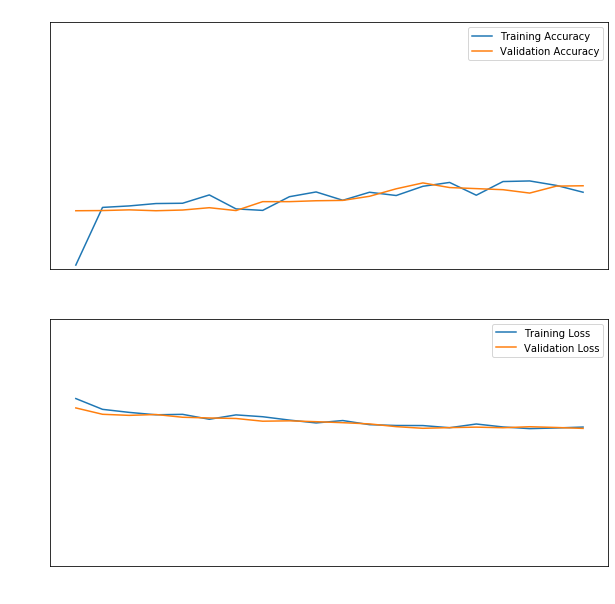

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.setp(plt.legend().get_texts(), color='black')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.setp(plt.legend().get_texts(), color='black')
plt.ylabel('Cross Entropy')
plt.ylim([0.0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=3)
print('Loss:', test_loss)
print('Accuracy:', test_acc)

Loss: 0.5513013047831399
Accuracy: 0.71921355
